# Computer Assignment 4: CNN Segmentation
## Alaqian Zafar - aaz7118

## Table of Contents
- <a href='#p1a'>Part (a)</a>
- <a href='#p1b'>Part (b)</a>
- <a href='#p1c'>Part (c)</a>
    - [Architecture](#Architecture)
    - [Loss Function](#Loss-Function)
- <a href='#p1d'>Part (d)</a>
- <a href='#p2a'>Part (e)</a>
- <a href='#p2b'>Part (f)</a>
- <a href='#p2c'>Part (g)</a>

In [110]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

%matplotlib inline

In [111]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/ECE-GY 6123 Image and Video Processing/Computer Assignments/CA04/archive'
except:
    path = 'archive'

<a id='p1a'></a>
##### (a) Cut the FudanPed dataset into an 80-10-10 train-val-test split.

[Table of Contents](#Table-of-Contents)

In [112]:
image_paths = sorted([os.path.join(path, "PNGImages", image) for image in os.listdir(os.path.join(path, "PNGImages"))])
mask_paths = sorted([os.path.join(path, "PedMasks", mask) for mask in os.listdir(os.path.join(path, "PedMasks"))])

indices = list(range(len(image_paths)))
train_indices = random.sample(indices, k=int(len(indices)*0.8))
val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))
test_indices = list(set(indices)-set(train_indices)-set(val_indices))

train_image_paths = [image_paths[i] for i in train_indices]
train_mask_paths = [mask_paths[i] for i in train_indices]
val_image_paths = [image_paths[i] for i in val_indices]
val_mask_paths = [mask_paths[i] for i in val_indices]
test_image_paths = [image_paths[i] for i in test_indices]
test_mask_paths = [mask_paths[i] for i in test_indices]

def square_pad(image):
    h_diff = max(image.shape) - image.shape[0]
    w_diff = max(image.shape) - image.shape[1]

    top = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    bottom = h_diff // 2
    left = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2    
    right = w_diff // 2
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)
    return padded_image, image.shape

def remove_pad(padded_image, original_shape):
    h_diff = padded_image.shape[0] - original_shape[0]
    w_diff = padded_image.shape[1] - original_shape[1]

    h_start = (h_diff + 1) // 2 if h_diff % 2 == 1 else h_diff // 2
    h_end = padded_image.shape[0] - h_diff // 2
    w_start = (w_diff + 1) // 2 if w_diff % 2 == 1 else w_diff // 2
    w_end = padded_image.shape[1] - w_diff // 2

    return padded_image[h_start:h_end, w_start:w_end]

class PennFudanDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=None, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        # Set all values greater-than or equal-to 1 to 255.
        mask = np.clip(mask, 0, 1)*255
        if self.transform or self.image_size:
            merged_image = np.concatenate((image, mask[:, :, None]), axis=2)
            #merged_image, merged_shape = square_pad(merged_image)
            merged_image = transforms.ToTensor()(merged_image)
            if self.transform:
                merged_image = self.transform(merged_image)
            if self.image_size:
                merged_image = transforms.Resize((self.image_size, self.image_size))(merged_image)
            image = merged_image[:3, :, :]
            mask = merged_image[3, :, :].unsqueeze(0)
            return image, mask, 0#merged_shape
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)
        return image, mask

C:\Users\Alqia\AppData\Local\Temp\ipykernel_6284\2698079577.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  val_indices = random.sample(set(indices)-set(train_indices), k=int(len(indices)*0.1))


<a id='p1b'></a>
##### (b) Apply data augmentation to your dataset during training and show an example of your data augmentation in your report.

[Table of Contents](#Table-of-Contents)

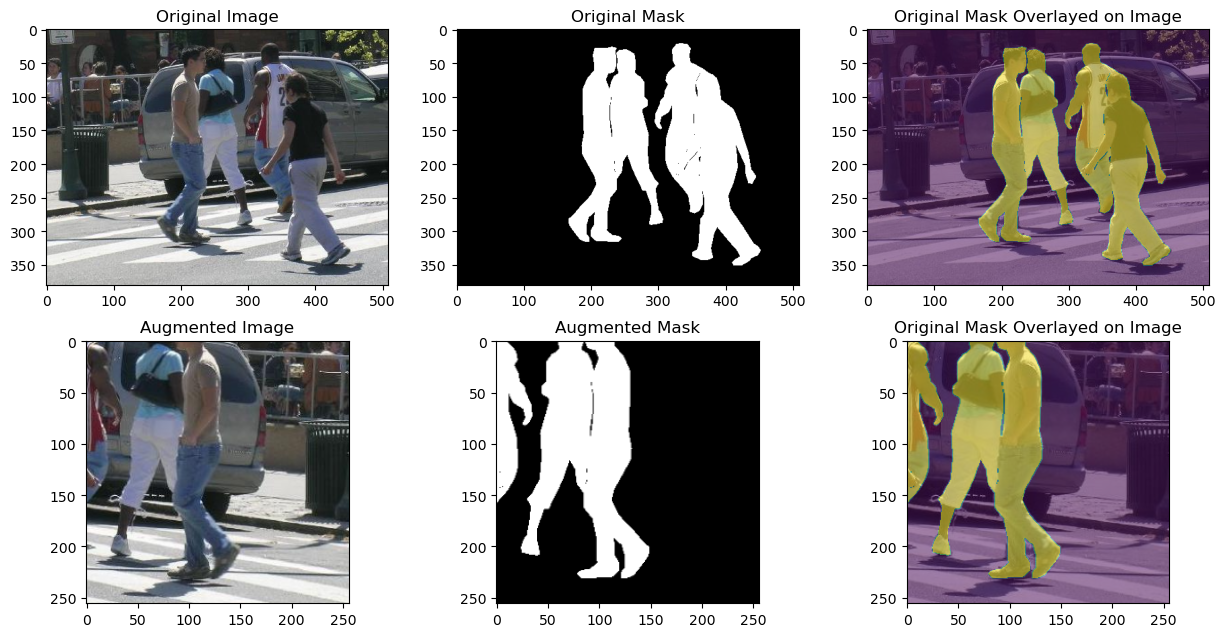

In [113]:
# Plot a subplot of the original and the augmented image and mask
train_dataset = PennFudanDataset(train_image_paths, train_mask_paths)
image, mask = train_dataset[0]
fig, ax = plt.subplots(2, 3, figsize=(15, 7.5))
ax[0,0].imshow(image.permute(1, 2, 0))
ax[0,0].set_title("Original Image")
ax[0,1].imshow(mask.squeeze(), cmap="gray")
ax[0,1].set_title("Original Mask")
ax[0,2].imshow(image.permute(1, 2, 0))
ax[0,2].imshow(mask.squeeze(), alpha=0.5)
ax[0,2].set_title("Original Mask Overlayed on Image")

image_size = 256

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=image_size,scale=(0.35, 1.0), ratio=(1.0, 1.0))])
augmented_train_dataset = PennFudanDataset(
    train_image_paths, 
    train_mask_paths,
    transform=augmentation)
image, mask, _ = augmented_train_dataset[0]
ax[1,0].imshow(image.permute(1, 2, 0))
ax[1,0].set_title("Augmented Image")
ax[1,1].imshow(mask.squeeze(),cmap="gray")
ax[1,1].set_title("Augmented Mask")
ax[1,2].imshow(image.permute(1, 2, 0))
ax[1,2].imshow(mask.squeeze(), alpha=0.5)
ax[1,2].set_title("Original Mask Overlayed on Image")

batchsize = 8

test_dataset = PennFudanDataset(test_image_paths, test_mask_paths, image_size=image_size)

val_dataset = PennFudanDataset(val_image_paths, val_mask_paths, image_size=image_size)

<a id='p1c'></a>
##### (c) Implement and train a CNN for binary segmentation on your train split. Describe your network architecture, loss function, and any training hyper-parameters. You may implement any architecture you'd like, **but the implementation must be your own code.**

[Table of Contents](#Table-of-Contents)

#### Architecture

`x` (input) → `Conv_BN_ReLU1` → `Downsample1` → `x1` → `x2` → `Conv_BN_ReLU2` → `x3` → `Downsample2` → `x4` → `Conv_BN_ReLU3` → `x5` → `Upsample1` → `x6` → `cat(x3)` → `x7` → `Conv_BN_ReLU4` → `x8` → `Upsamle2` → `x9` → `cat(x1)` → `x10` → `Conv_BN_ReLU5` → `x11` → `conv6` → `x12` → `sigmoid` → `x13` (output)

![Architecture](UNET.png)

In [114]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.Conv_BN_ReLU1 = self._Conv_BN_ReLU(3, 16)
        self.Downsample1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU2 = self._Conv_BN_ReLU(16, 32)
        self.Downsample2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Conv_BN_ReLU3 = self._Conv_BN_ReLU(32, 32)
        self.Upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU4 = self._Conv_BN_ReLU(64, 16)
        self.Upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Conv_BN_ReLU5 = self._Conv_BN_ReLU(32, 16)
        self.Conv6 = nn.Conv2d(16, 1, kernel_size=1)

    def _Conv_BN_ReLU(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x1 = self.Conv_BN_ReLU1(x) # 3x128x128 -> 16x128x128
        x2 = self.Downsample1(x1) # 16x128x128 -> 16x64x64
        x3 = self.Conv_BN_ReLU2(x2) # 16x64x64 -> 32x64x64
        x4 = self.Downsample2(x3) # 32x64x64 -> 32x32x32
        x5 = self.Conv_BN_ReLU3(x4) # 32x32x32 -> 32x32x32
        x6 = self.Upsample1(x5) # 32x32x32 -> 32x64x64
        x7 = torch.cat((x6, x3), dim=1) # 32x64x64 + 32x64x64 -> 64x64x64
        x8 = self.Conv_BN_ReLU4(x7) # 64x64x64 -> 16x64x64
        x9 = self.Upsample2(x8) # 16x64x64 -> 16x128x128
        x10 = torch.cat((x9, x1), dim=1) # 16x128x128 + 16x128x128 -> 32x128x128
        x11 = self.Conv_BN_ReLU5(x10) # 32x128x128 -> 16x128x128
        x12 = self.Conv6(x11) # 16x128x128 -> 1x128x128
        x13 = torch.sigmoid(x12) # 1x128x128 -> 1x128x128
        return x13

#### Loss Function

[Table of Contents](#Table-of-Contents)

In [115]:
def dice_coefficient(output, ground_truth):
    numerical_stability = 1.
    output = output.view(-1)
    ground_truth = ground_truth.view(-1)
    intersection = (output * ground_truth).sum()
    return (2. * intersection + numerical_stability) / (output.sum() + ground_truth.sum() + numerical_stability)

class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()
    
    def forward(self, output, ground_truth):
        return 1 - dice_coefficient(output, ground_truth)

#### Training

[Table of Contents](#Table-of-Contents)

In [116]:
def save_checkpoint(filename, model, optimizer, epoch, val_loss):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "loss": val_loss}, 
        filename)
    
def load_checkpoint(filename, model, optimizer):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    return model, optimizer, epoch, loss

def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_loss = 0
    for image, mask, _ in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        pred = (model(image))
        loss = criterion(pred, mask)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for image, mask, _ in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            pred = torch.round(model(image))
            loss = criterion(pred, mask)
            val_loss += loss.item()
    return val_loss / len(val_loader)


NUM_EPOCHS = 100
learning_rate=0.001

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNET().to(device)
criterion = SoftDiceLoss()#nn.BCELoss()#
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, min_lr=1e-20,eps=1e-20,patience=25)

checkpoint_dir = "./checkpoints copy"
checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pth")

train_losses = []
val_losses = []
val_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
train_loader = DataLoader(augmented_train_dataset, batch_size=batchsize, shuffle=True)

In [117]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while epoch < NUM_EPOCHS:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)

100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 1	Train Loss: 0.6223	Val Loss: 1.0000	Learning rate: 0.001
Checkpoint saved:	epoch = 1,	val loss = 1.0000


100%|██████████| 17/17 [00:06<00:00,  2.76it/s]


Epoch: 2	Train Loss: 0.5551	Val Loss: 0.7395	Learning rate: 0.001
Checkpoint saved:	epoch = 2,	val loss = 0.7395


100%|██████████| 17/17 [00:06<00:00,  2.59it/s]


Epoch: 3	Train Loss: 0.5143	Val Loss: 0.5396	Learning rate: 0.001
Checkpoint saved:	epoch = 3,	val loss = 0.5396


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 4	Train Loss: 0.4956	Val Loss: 0.5308	Learning rate: 0.001
Checkpoint saved:	epoch = 4,	val loss = 0.5308


100%|██████████| 17/17 [00:08<00:00,  2.09it/s]


Epoch: 5	Train Loss: 0.4664	Val Loss: 0.5186	Learning rate: 0.001
Checkpoint saved:	epoch = 5,	val loss = 0.5186


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 6	Train Loss: 0.4420	Val Loss: 0.4684	Learning rate: 0.001
Checkpoint saved:	epoch = 6,	val loss = 0.4684


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Epoch: 7	Train Loss: 0.4330	Val Loss: 0.4863	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch: 8	Train Loss: 0.4299	Val Loss: 0.5441	Learning rate: 0.001


100%|██████████| 17/17 [00:08<00:00,  2.12it/s]


Epoch: 9	Train Loss: 0.4011	Val Loss: 0.5172	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.51it/s]


Epoch: 10	Train Loss: 0.3862	Val Loss: 0.4141	Learning rate: 0.001
Checkpoint saved:	epoch = 10,	val loss = 0.4141


100%|██████████| 17/17 [00:06<00:00,  2.51it/s]


Epoch: 11	Train Loss: 0.3672	Val Loss: 0.4343	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 12	Train Loss: 0.3582	Val Loss: 0.4012	Learning rate: 0.001
Checkpoint saved:	epoch = 12,	val loss = 0.4012


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


Epoch: 13	Train Loss: 0.3642	Val Loss: 0.3863	Learning rate: 0.001
Checkpoint saved:	epoch = 13,	val loss = 0.3863


100%|██████████| 17/17 [00:08<00:00,  2.08it/s]


Epoch: 14	Train Loss: 0.3437	Val Loss: 0.4232	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 15	Train Loss: 0.3347	Val Loss: 0.3571	Learning rate: 0.001
Checkpoint saved:	epoch = 15,	val loss = 0.3571


100%|██████████| 17/17 [00:07<00:00,  2.42it/s]


Epoch: 16	Train Loss: 0.3235	Val Loss: 0.3720	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 17	Train Loss: 0.3284	Val Loss: 0.4378	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 18	Train Loss: 0.3300	Val Loss: 0.4884	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 19	Train Loss: 0.3284	Val Loss: 0.4037	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 20	Train Loss: 0.3120	Val Loss: 0.3843	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 21	Train Loss: 0.3080	Val Loss: 0.4314	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 22	Train Loss: 0.3012	Val Loss: 0.3571	Learning rate: 0.001


100%|██████████| 17/17 [00:09<00:00,  1.88it/s]


Epoch: 23	Train Loss: 0.2900	Val Loss: 0.3607	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.96it/s]


Epoch: 24	Train Loss: 0.3024	Val Loss: 0.4453	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.40it/s]


Epoch: 25	Train Loss: 0.2940	Val Loss: 0.4359	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 26	Train Loss: 0.2792	Val Loss: 0.3202	Learning rate: 0.001
Checkpoint saved:	epoch = 26,	val loss = 0.3202


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]


Epoch: 27	Train Loss: 0.2872	Val Loss: 0.3741	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.17it/s]


Epoch: 28	Train Loss: 0.2784	Val Loss: 0.3490	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 29	Train Loss: 0.3048	Val Loss: 0.3462	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 30	Train Loss: 0.2936	Val Loss: 0.3955	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.78it/s]


Epoch: 31	Train Loss: 0.2769	Val Loss: 0.3415	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch: 32	Train Loss: 0.2884	Val Loss: 0.3110	Learning rate: 0.001
Checkpoint saved:	epoch = 32,	val loss = 0.3110


100%|██████████| 17/17 [00:06<00:00,  2.66it/s]


Epoch: 33	Train Loss: 0.2851	Val Loss: 0.3676	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 34	Train Loss: 0.2752	Val Loss: 0.3273	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


Epoch: 35	Train Loss: 0.2673	Val Loss: 0.3038	Learning rate: 0.001
Checkpoint saved:	epoch = 35,	val loss = 0.3038


100%|██████████| 17/17 [00:06<00:00,  2.82it/s]


Epoch: 36	Train Loss: 0.2718	Val Loss: 0.3457	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 37	Train Loss: 0.2606	Val Loss: 0.2752	Learning rate: 0.001
Checkpoint saved:	epoch = 37,	val loss = 0.2752


100%|██████████| 17/17 [00:06<00:00,  2.56it/s]


Epoch: 38	Train Loss: 0.2564	Val Loss: 0.3271	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 39	Train Loss: 0.2514	Val Loss: 0.3070	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 40	Train Loss: 0.2628	Val Loss: 0.3763	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


Epoch: 41	Train Loss: 0.2664	Val Loss: 0.3527	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 42	Train Loss: 0.2567	Val Loss: 0.2851	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 43	Train Loss: 0.2597	Val Loss: 0.4000	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


Epoch: 44	Train Loss: 0.2465	Val Loss: 0.3397	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.33it/s]


Epoch: 45	Train Loss: 0.2424	Val Loss: 0.3044	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epoch: 46	Train Loss: 0.2454	Val Loss: 0.3230	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Epoch: 47	Train Loss: 0.2541	Val Loss: 0.4450	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch: 48	Train Loss: 0.2375	Val Loss: 0.2706	Learning rate: 0.001
Checkpoint saved:	epoch = 48,	val loss = 0.2706


100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


Epoch: 49	Train Loss: 0.2358	Val Loss: 0.2854	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.63it/s]


Epoch: 50	Train Loss: 0.2264	Val Loss: 0.3325	Learning rate: 0.001


In [118]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while val_loss > 0.3:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)

Checkpoint loaded:	start epoch = 50,	val loss = 0.3325


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 51	Train Loss: 0.2322	Val Loss: 0.4195	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 52	Train Loss: 0.2506	Val Loss: 0.4503	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 53	Train Loss: 0.2340	Val Loss: 0.5389	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Epoch: 54	Train Loss: 0.2343	Val Loss: 0.4115	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 55	Train Loss: 0.2243	Val Loss: 0.2697	Learning rate: 0.001
Checkpoint saved:	epoch = 55,	val loss = 0.2697


In [119]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while val_loss > 0.25:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))

Checkpoint loaded:	start epoch = 55,	val loss = 0.2697


100%|██████████| 17/17 [00:03<00:00,  4.30it/s]


Epoch: 56	Train Loss: 0.2302	Val Loss: 0.3290	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.35it/s]


Epoch: 57	Train Loss: 0.2381	Val Loss: 0.2806	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 58	Train Loss: 0.2502	Val Loss: 0.3498	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.71it/s]


Epoch: 59	Train Loss: 0.2385	Val Loss: 0.3266	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 60	Train Loss: 0.2276	Val Loss: 0.3147	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.34it/s]


Epoch: 61	Train Loss: 0.2335	Val Loss: 0.3934	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.29it/s]


Epoch: 62	Train Loss: 0.2416	Val Loss: 0.2960	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.74it/s]


Epoch: 63	Train Loss: 0.2222	Val Loss: 0.3171	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.35it/s]


Epoch: 64	Train Loss: 0.2269	Val Loss: 0.4436	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


Epoch: 65	Train Loss: 0.2263	Val Loss: 0.3121	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.60it/s]


Epoch: 66	Train Loss: 0.2276	Val Loss: 0.2546	Learning rate: 0.001
Checkpoint saved:	epoch = 66,	val loss = 0.2546


100%|██████████| 17/17 [00:07<00:00,  2.22it/s]


Epoch: 67	Train Loss: 0.2182	Val Loss: 0.3372	Learning rate: 0.001


100%|██████████| 17/17 [00:06<00:00,  2.62it/s]


Epoch: 68	Train Loss: 0.2332	Val Loss: 0.3057	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.32it/s]


Epoch: 69	Train Loss: 0.2088	Val Loss: 0.2821	Learning rate: 0.001


100%|██████████| 17/17 [00:07<00:00,  2.14it/s]


Epoch: 70	Train Loss: 0.2161	Val Loss: 0.4282	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 71	Train Loss: 0.2264	Val Loss: 0.3150	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 72	Train Loss: 0.2377	Val Loss: 0.3023	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.79it/s]


Epoch: 73	Train Loss: 0.2171	Val Loss: 0.2612	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 74	Train Loss: 0.2104	Val Loss: 0.3276	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.93it/s]


Epoch: 75	Train Loss: 0.2212	Val Loss: 0.3310	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 76	Train Loss: 0.2158	Val Loss: 0.3087	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.76it/s]


Epoch: 77	Train Loss: 0.2202	Val Loss: 0.2918	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 78	Train Loss: 0.2124	Val Loss: 0.2700	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]


Epoch: 79	Train Loss: 0.2061	Val Loss: 0.2571	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.63it/s]


Epoch: 80	Train Loss: 0.2140	Val Loss: 0.6369	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


Epoch: 81	Train Loss: 0.2207	Val Loss: 0.2908	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.71it/s]


Epoch: 82	Train Loss: 0.2079	Val Loss: 0.2827	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.94it/s]


Epoch: 83	Train Loss: 0.2048	Val Loss: 0.3644	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


Epoch: 84	Train Loss: 0.1913	Val Loss: 0.3105	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.74it/s]


Epoch: 85	Train Loss: 0.1955	Val Loss: 0.2398	Learning rate: 0.001
Checkpoint saved:	epoch = 85,	val loss = 0.2398


In [120]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while val_loss > 0.23:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))

Checkpoint loaded:	start epoch = 85,	val loss = 0.2398


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch: 86	Train Loss: 0.2113	Val Loss: 0.2473	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.74it/s]


Epoch: 87	Train Loss: 0.2201	Val Loss: 0.3084	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 88	Train Loss: 0.2050	Val Loss: 0.2853	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.78it/s]


Epoch: 89	Train Loss: 0.1915	Val Loss: 0.2547	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Epoch: 90	Train Loss: 0.2042	Val Loss: 0.2819	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.88it/s]


Epoch: 91	Train Loss: 0.2102	Val Loss: 0.2479	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch: 92	Train Loss: 0.1969	Val Loss: 0.2548	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.86it/s]


Epoch: 93	Train Loss: 0.2022	Val Loss: 0.3465	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 94	Train Loss: 0.2077	Val Loss: 0.3162	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch: 95	Train Loss: 0.2107	Val Loss: 0.3593	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 96	Train Loss: 0.1998	Val Loss: 0.2859	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


Epoch: 97	Train Loss: 0.1994	Val Loss: 0.3044	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.07it/s]


Epoch: 98	Train Loss: 0.2070	Val Loss: 0.2694	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.53it/s]


Epoch: 99	Train Loss: 0.2049	Val Loss: 0.3522	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 100	Train Loss: 0.1873	Val Loss: 0.2416	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.79it/s]


Epoch: 101	Train Loss: 0.2101	Val Loss: 0.2608	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 102	Train Loss: 0.1962	Val Loss: 0.3064	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.65it/s]


Epoch: 103	Train Loss: 0.1915	Val Loss: 0.4426	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 104	Train Loss: 0.1999	Val Loss: 0.2991	Learning rate: 0.001


100%|██████████| 17/17 [00:04<00:00,  3.64it/s]


Epoch: 105	Train Loss: 0.2019	Val Loss: 0.2633	Learning rate: 0.001


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 106	Train Loss: 0.1896	Val Loss: 0.2777	Learning rate: 0.001
Epoch 00056: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 17/17 [00:04<00:00,  3.69it/s]


Epoch: 107	Train Loss: 0.1874	Val Loss: 0.2314	Learning rate: 0.0001
Checkpoint saved:	epoch = 107,	val loss = 0.2314


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 108	Train Loss: 0.1742	Val Loss: 0.2362	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.81it/s]


Epoch: 109	Train Loss: 0.1837	Val Loss: 0.2273	Learning rate: 0.0001
Checkpoint saved:	epoch = 109,	val loss = 0.2273


In [124]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
while val_loss > 0.2:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))

Checkpoint loaded:	start epoch = 110,	val loss = 0.2246


100%|██████████| 17/17 [00:04<00:00,  4.19it/s]


Epoch: 111	Train Loss: 0.1720	Val Loss: 0.2224	Learning rate: 0.0001
Checkpoint saved:	epoch = 111,	val loss = 0.2224


100%|██████████| 17/17 [00:04<00:00,  3.70it/s]


Epoch: 112	Train Loss: 0.1717	Val Loss: 0.2291	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.75it/s]


Epoch: 113	Train Loss: 0.1720	Val Loss: 0.2266	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 114	Train Loss: 0.1698	Val Loss: 0.2266	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.95it/s]


Epoch: 115	Train Loss: 0.1779	Val Loss: 0.2323	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.74it/s]


Epoch: 116	Train Loss: 0.1706	Val Loss: 0.2308	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  2.93it/s]


Epoch: 117	Train Loss: 0.1716	Val Loss: 0.2305	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


Epoch: 118	Train Loss: 0.1728	Val Loss: 0.2309	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.74it/s]


Epoch: 119	Train Loss: 0.1720	Val Loss: 0.2319	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Epoch: 120	Train Loss: 0.1677	Val Loss: 0.2377	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.55it/s]


Epoch: 121	Train Loss: 0.1754	Val Loss: 0.2296	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]


Epoch: 122	Train Loss: 0.1694	Val Loss: 0.2325	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.93it/s]


Epoch: 123	Train Loss: 0.1729	Val Loss: 0.2284	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.77it/s]


Epoch: 124	Train Loss: 0.1792	Val Loss: 0.2303	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 125	Train Loss: 0.1721	Val Loss: 0.2239	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.75it/s]


Epoch: 126	Train Loss: 0.1729	Val Loss: 0.2255	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  2.91it/s]


Epoch: 127	Train Loss: 0.1688	Val Loss: 0.2285	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.98it/s]


Epoch: 128	Train Loss: 0.1719	Val Loss: 0.2231	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]


Epoch: 129	Train Loss: 0.1637	Val Loss: 0.2288	Learning rate: 0.0001


100%|██████████| 17/17 [00:03<00:00,  4.28it/s]


Epoch: 130	Train Loss: 0.1704	Val Loss: 0.2241	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 131	Train Loss: 0.1687	Val Loss: 0.2216	Learning rate: 0.0001
Checkpoint saved:	epoch = 131,	val loss = 0.2216


100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


Epoch: 132	Train Loss: 0.1684	Val Loss: 0.2222	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Epoch: 133	Train Loss: 0.1723	Val Loss: 0.2261	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.94it/s]


Epoch: 134	Train Loss: 0.1815	Val Loss: 0.2316	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


Epoch: 135	Train Loss: 0.1698	Val Loss: 0.2236	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.72it/s]


Epoch: 136	Train Loss: 0.1676	Val Loss: 0.2279	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.84it/s]


Epoch: 137	Train Loss: 0.1660	Val Loss: 0.2254	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.61it/s]


Epoch: 138	Train Loss: 0.1706	Val Loss: 0.2260	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.77it/s]


Epoch: 139	Train Loss: 0.1823	Val Loss: 0.2216	Learning rate: 0.0001
Checkpoint saved:	epoch = 139,	val loss = 0.2216


100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Epoch: 140	Train Loss: 0.1723	Val Loss: 0.2226	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.16it/s]


Epoch: 141	Train Loss: 0.1674	Val Loss: 0.2215	Learning rate: 0.0001
Checkpoint saved:	epoch = 141,	val loss = 0.2215


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 142	Train Loss: 0.1700	Val Loss: 0.2223	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.10it/s]


Epoch: 143	Train Loss: 0.1739	Val Loss: 0.2230	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]


Epoch: 144	Train Loss: 0.1822	Val Loss: 0.2224	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.94it/s]


Epoch: 145	Train Loss: 0.1720	Val Loss: 0.2221	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]


Epoch: 146	Train Loss: 0.1642	Val Loss: 0.2216	Learning rate: 0.0001


100%|██████████| 17/17 [00:03<00:00,  4.31it/s]


Epoch: 147	Train Loss: 0.1609	Val Loss: 0.2242	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]


Epoch: 148	Train Loss: 0.1751	Val Loss: 0.2240	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 149	Train Loss: 0.1699	Val Loss: 0.2233	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 150	Train Loss: 0.1625	Val Loss: 0.2283	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.03it/s]


Epoch: 151	Train Loss: 0.1703	Val Loss: 0.2214	Learning rate: 0.0001
Checkpoint saved:	epoch = 151,	val loss = 0.2214


100%|██████████| 17/17 [00:04<00:00,  3.90it/s]


Epoch: 152	Train Loss: 0.1704	Val Loss: 0.2290	Learning rate: 0.0001


100%|██████████| 17/17 [00:06<00:00,  2.70it/s]


Epoch: 153	Train Loss: 0.1750	Val Loss: 0.2223	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


Epoch: 154	Train Loss: 0.1637	Val Loss: 0.2263	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]


Epoch: 155	Train Loss: 0.1676	Val Loss: 0.2229	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


Epoch: 156	Train Loss: 0.1654	Val Loss: 0.2219	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 157	Train Loss: 0.1715	Val Loss: 0.2238	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.71it/s]


Epoch: 158	Train Loss: 0.1594	Val Loss: 0.2223	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 159	Train Loss: 0.1656	Val Loss: 0.2299	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.11it/s]


Epoch: 160	Train Loss: 0.1547	Val Loss: 0.2217	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch: 161	Train Loss: 0.1637	Val Loss: 0.2216	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.93it/s]


Epoch: 162	Train Loss: 0.1664	Val Loss: 0.2267	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  2.89it/s]


Epoch: 163	Train Loss: 0.1597	Val Loss: 0.2189	Learning rate: 0.0001
Checkpoint saved:	epoch = 163,	val loss = 0.2189


100%|██████████| 17/17 [00:04<00:00,  4.19it/s]


Epoch: 164	Train Loss: 0.1651	Val Loss: 0.2199	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.07it/s]


Epoch: 165	Train Loss: 0.1674	Val Loss: 0.2167	Learning rate: 0.0001
Checkpoint saved:	epoch = 165,	val loss = 0.2167


100%|██████████| 17/17 [00:05<00:00,  3.35it/s]


Epoch: 166	Train Loss: 0.1655	Val Loss: 0.2217	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.95it/s]


Epoch: 167	Train Loss: 0.1710	Val Loss: 0.2198	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch: 168	Train Loss: 0.1737	Val Loss: 0.2215	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.98it/s]


Epoch: 169	Train Loss: 0.1708	Val Loss: 0.2158	Learning rate: 0.0001
Checkpoint saved:	epoch = 169,	val loss = 0.2158


100%|██████████| 17/17 [00:05<00:00,  3.30it/s]


Epoch: 170	Train Loss: 0.1649	Val Loss: 0.2262	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.01it/s]


Epoch: 171	Train Loss: 0.1657	Val Loss: 0.2168	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


Epoch: 172	Train Loss: 0.1604	Val Loss: 0.2110	Learning rate: 0.0001
Checkpoint saved:	epoch = 172,	val loss = 0.2110


100%|██████████| 17/17 [00:04<00:00,  3.65it/s]


Epoch: 173	Train Loss: 0.1633	Val Loss: 0.2123	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 174	Train Loss: 0.1670	Val Loss: 0.2173	Learning rate: 0.0001


100%|██████████| 17/17 [00:03<00:00,  4.27it/s]


Epoch: 175	Train Loss: 0.1638	Val Loss: 0.2145	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.83it/s]


Epoch: 176	Train Loss: 0.1598	Val Loss: 0.2228	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]


Epoch: 177	Train Loss: 0.1627	Val Loss: 0.2235	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  4.01it/s]


Epoch: 178	Train Loss: 0.1696	Val Loss: 0.2214	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 179	Train Loss: 0.1632	Val Loss: 0.2224	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.86it/s]


Epoch: 180	Train Loss: 0.1728	Val Loss: 0.2189	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 181	Train Loss: 0.1674	Val Loss: 0.2226	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.82it/s]


Epoch: 182	Train Loss: 0.1609	Val Loss: 0.2202	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.32it/s]


Epoch: 183	Train Loss: 0.1662	Val Loss: 0.2239	Learning rate: 0.0001


100%|██████████| 17/17 [00:03<00:00,  4.39it/s]


Epoch: 184	Train Loss: 0.1594	Val Loss: 0.2194	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Epoch: 185	Train Loss: 0.1633	Val Loss: 0.2202	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.82it/s]


Epoch: 186	Train Loss: 0.1603	Val Loss: 0.2235	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.70it/s]


Epoch: 187	Train Loss: 0.1597	Val Loss: 0.2208	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 188	Train Loss: 0.1623	Val Loss: 0.2192	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.70it/s]


Epoch: 189	Train Loss: 0.1634	Val Loss: 0.2130	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Epoch: 190	Train Loss: 0.1647	Val Loss: 0.2175	Learning rate: 0.0001


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch: 191	Train Loss: 0.1638	Val Loss: 0.2244	Learning rate: 0.0001


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 192	Train Loss: 0.1659	Val Loss: 0.2163	Learning rate: 0.0001


100%|██████████| 17/17 [00:03<00:00,  4.30it/s]


Epoch: 193	Train Loss: 0.1597	Val Loss: 0.2159	Learning rate: 0.0001
Epoch 00144: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 194	Train Loss: 0.1625	Val Loss: 0.2150	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.78it/s]


Epoch: 195	Train Loss: 0.1578	Val Loss: 0.2165	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 196	Train Loss: 0.1613	Val Loss: 0.2162	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  4.18it/s]


Epoch: 197	Train Loss: 0.1585	Val Loss: 0.2146	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


Epoch: 198	Train Loss: 0.1637	Val Loss: 0.2164	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 199	Train Loss: 0.1627	Val Loss: 0.2164	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 200	Train Loss: 0.1544	Val Loss: 0.2152	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.37it/s]


Epoch: 201	Train Loss: 0.1648	Val Loss: 0.2156	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.97it/s]


Epoch: 202	Train Loss: 0.1618	Val Loss: 0.2141	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]


Epoch: 203	Train Loss: 0.1670	Val Loss: 0.2136	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.90it/s]


Epoch: 204	Train Loss: 0.1704	Val Loss: 0.2138	Learning rate: 1e-05


100%|██████████| 17/17 [00:06<00:00,  2.75it/s]


Epoch: 205	Train Loss: 0.1630	Val Loss: 0.2140	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.92it/s]


Epoch: 206	Train Loss: 0.1590	Val Loss: 0.2149	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 207	Train Loss: 0.1565	Val Loss: 0.2154	Learning rate: 1e-05


100%|██████████| 17/17 [00:03<00:00,  4.27it/s]


Epoch: 208	Train Loss: 0.1582	Val Loss: 0.2148	Learning rate: 1e-05


100%|██████████| 17/17 [00:06<00:00,  2.72it/s]


Epoch: 209	Train Loss: 0.1604	Val Loss: 0.2145	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  4.13it/s]


Epoch: 210	Train Loss: 0.1652	Val Loss: 0.2156	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.66it/s]


Epoch: 211	Train Loss: 0.1628	Val Loss: 0.2154	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  2.97it/s]


Epoch: 212	Train Loss: 0.1589	Val Loss: 0.2144	Learning rate: 1e-05


100%|██████████| 17/17 [00:04<00:00,  3.77it/s]


Epoch: 213	Train Loss: 0.1641	Val Loss: 0.2156	Learning rate: 1e-05


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


Epoch: 214	Train Loss: 0.1589	Val Loss: 0.2152	Learning rate: 1e-05
Epoch 00165: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 17/17 [00:04<00:00,  3.60it/s]


Epoch: 215	Train Loss: 0.1583	Val Loss: 0.2164	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 216	Train Loss: 0.1614	Val Loss: 0.2180	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  4.03it/s]


Epoch: 217	Train Loss: 0.1596	Val Loss: 0.2164	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.06it/s]


Epoch: 218	Train Loss: 0.1604	Val Loss: 0.2160	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.75it/s]


Epoch: 219	Train Loss: 0.1579	Val Loss: 0.2153	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]


Epoch: 220	Train Loss: 0.1497	Val Loss: 0.2160	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.91it/s]


Epoch: 221	Train Loss: 0.1600	Val Loss: 0.2155	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Epoch: 222	Train Loss: 0.1584	Val Loss: 0.2162	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.43it/s]


Epoch: 223	Train Loss: 0.1558	Val Loss: 0.2154	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Epoch: 224	Train Loss: 0.1559	Val Loss: 0.2160	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:03<00:00,  4.26it/s]


Epoch: 225	Train Loss: 0.1619	Val Loss: 0.2155	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.90it/s]


Epoch: 226	Train Loss: 0.1675	Val Loss: 0.2155	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 227	Train Loss: 0.1541	Val Loss: 0.2156	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.77it/s]


Epoch: 228	Train Loss: 0.1596	Val Loss: 0.2157	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.44it/s]


Epoch: 229	Train Loss: 0.1621	Val Loss: 0.2158	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  3.98it/s]


Epoch: 230	Train Loss: 0.1632	Val Loss: 0.2152	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.33it/s]


Epoch: 231	Train Loss: 0.1540	Val Loss: 0.2155	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  4.05it/s]


Epoch: 232	Train Loss: 0.1601	Val Loss: 0.2171	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:05<00:00,  3.39it/s]


Epoch: 233	Train Loss: 0.1661	Val Loss: 0.2153	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:03<00:00,  4.45it/s]


Epoch: 234	Train Loss: 0.1590	Val Loss: 0.2151	Learning rate: 1.0000000000000002e-06


100%|██████████| 17/17 [00:04<00:00,  4.20it/s]


Epoch: 235	Train Loss: 0.1574	Val Loss: 0.2149	Learning rate: 1.0000000000000002e-06
Epoch 00186: reducing learning rate of group 0 to 1.0000e-07.


100%|██████████| 17/17 [00:04<00:00,  4.10it/s]


Epoch: 236	Train Loss: 0.1493	Val Loss: 0.2135	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.04it/s]


Epoch: 237	Train Loss: 0.1602	Val Loss: 0.2146	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Epoch: 238	Train Loss: 0.1572	Val Loss: 0.2150	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.69it/s]


Epoch: 239	Train Loss: 0.1627	Val Loss: 0.2155	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


Epoch: 240	Train Loss: 0.1524	Val Loss: 0.2149	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.91it/s]


Epoch: 241	Train Loss: 0.1566	Val Loss: 0.2153	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 242	Train Loss: 0.1558	Val Loss: 0.2150	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:03<00:00,  4.33it/s]


Epoch: 243	Train Loss: 0.1542	Val Loss: 0.2154	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.95it/s]


Epoch: 244	Train Loss: 0.1565	Val Loss: 0.2142	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]


Epoch: 245	Train Loss: 0.1643	Val Loss: 0.2142	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.85it/s]


Epoch: 246	Train Loss: 0.1586	Val Loss: 0.2140	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]


Epoch: 247	Train Loss: 0.1580	Val Loss: 0.2148	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.22it/s]


Epoch: 248	Train Loss: 0.1668	Val Loss: 0.2143	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]


Epoch: 249	Train Loss: 0.1563	Val Loss: 0.2144	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.05it/s]


Epoch: 250	Train Loss: 0.1654	Val Loss: 0.2157	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.47it/s]


Epoch: 251	Train Loss: 0.1595	Val Loss: 0.2149	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.89it/s]


Epoch: 252	Train Loss: 0.1573	Val Loss: 0.2156	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  4.09it/s]


Epoch: 253	Train Loss: 0.1688	Val Loss: 0.2153	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Epoch: 254	Train Loss: 0.1547	Val Loss: 0.2154	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:04<00:00,  3.87it/s]


Epoch: 255	Train Loss: 0.1601	Val Loss: 0.2145	Learning rate: 1.0000000000000002e-07


100%|██████████| 17/17 [00:05<00:00,  3.36it/s]


Epoch: 256	Train Loss: 0.1684	Val Loss: 0.2156	Learning rate: 1.0000000000000002e-07
Epoch 00207: reducing learning rate of group 0 to 1.0000e-08.


100%|██████████| 17/17 [00:04<00:00,  3.72it/s]


Epoch: 257	Train Loss: 0.1588	Val Loss: 0.2149	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:06<00:00,  2.79it/s]


Epoch: 258	Train Loss: 0.1700	Val Loss: 0.2148	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


Epoch: 259	Train Loss: 0.1583	Val Loss: 0.2159	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]


Epoch: 260	Train Loss: 0.1647	Val Loss: 0.2152	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.50it/s]


Epoch: 261	Train Loss: 0.1594	Val Loss: 0.2159	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:06<00:00,  2.65it/s]


Epoch: 262	Train Loss: 0.1617	Val Loss: 0.2151	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Epoch: 263	Train Loss: 0.1549	Val Loss: 0.2148	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:06<00:00,  2.53it/s]


Epoch: 264	Train Loss: 0.1606	Val Loss: 0.2153	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Epoch: 265	Train Loss: 0.1619	Val Loss: 0.2150	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  2.90it/s]


Epoch: 266	Train Loss: 0.1579	Val Loss: 0.2153	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]


Epoch: 267	Train Loss: 0.1686	Val Loss: 0.2148	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:06<00:00,  2.68it/s]


Epoch: 268	Train Loss: 0.1619	Val Loss: 0.2155	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  4.06it/s]


Epoch: 269	Train Loss: 0.1543	Val Loss: 0.2148	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Epoch: 270	Train Loss: 0.1602	Val Loss: 0.2164	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.72it/s]


Epoch: 271	Train Loss: 0.1597	Val Loss: 0.2153	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:05<00:00,  2.85it/s]


Epoch: 272	Train Loss: 0.1522	Val Loss: 0.2144	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.78it/s]


Epoch: 273	Train Loss: 0.1621	Val Loss: 0.2148	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.48it/s]


Epoch: 274	Train Loss: 0.1531	Val Loss: 0.2149	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:03<00:00,  4.40it/s]


Epoch: 275	Train Loss: 0.1611	Val Loss: 0.2162	Learning rate: 1.0000000000000004e-08


100%|██████████| 17/17 [00:04<00:00,  3.67it/s]


Epoch: 276	Train Loss: 0.1590	Val Loss: 0.2155	Learning rate: 1.0000000000000004e-08


 41%|████      | 7/17 [00:03<00:04,  2.31it/s]


KeyboardInterrupt: 

In [ ]:
if os.path.exists(checkpoint_path):
    model, optimizer, epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
    print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
else:
    epoch = 0
    val_loss = np.inf
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, min_lr=1e-20,eps=1e-20,patience=20)
while val_loss > 0.15:
    epoch += 1
    progress_bar = tqdm(train_loader)
    train_loss = train(model, progress_bar, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    print("Epoch: {}".format(epoch),
            "Train Loss: {:.4f}".format(train_loss),
            "Val Loss: {:.4f}".format(val_loss),
            "Learning rate: {}".format(optimizer.param_groups[0]['lr']),
            sep="\t")
    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if val_loss == np.min(val_losses):
        save_checkpoint(checkpoint_path, model, optimizer, epoch, val_loss)
        print("Checkpoint saved:\tepoch = {},\tval loss = {:.4f}".format(epoch, val_loss))

Checkpoint loaded:	start epoch = 277,	val loss = 0.2110


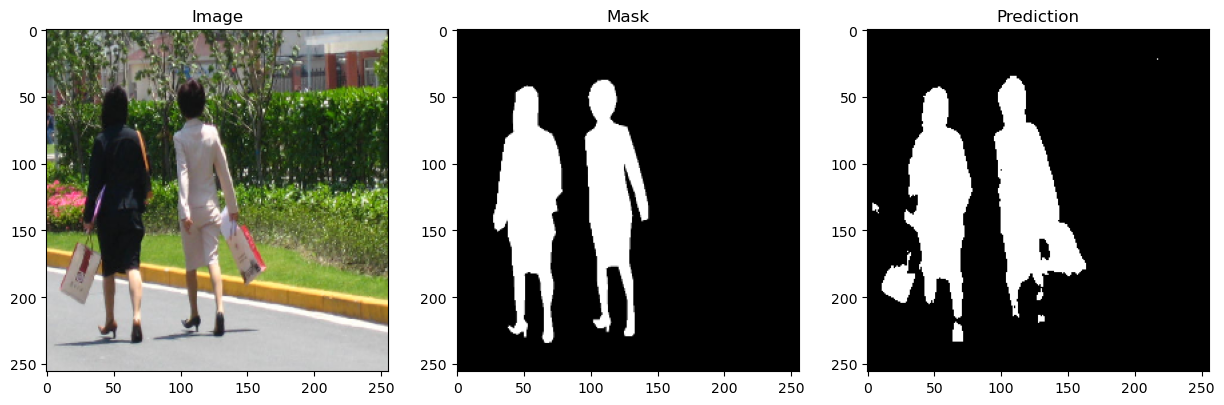

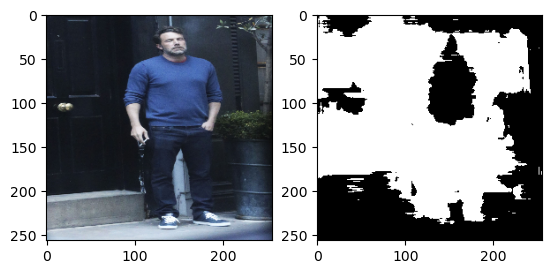

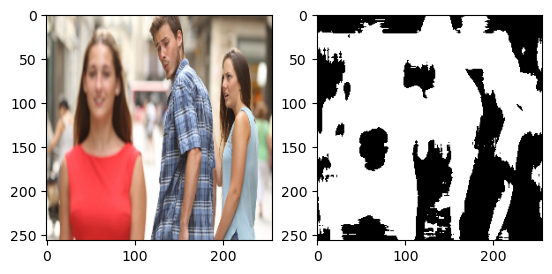

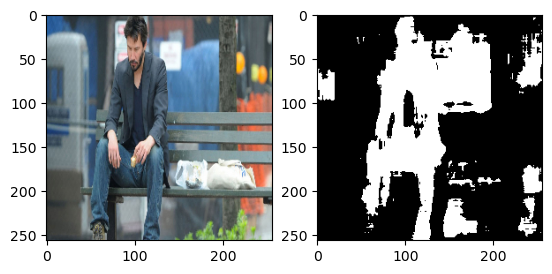

In [125]:
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
model, optimizer, start_epoch, val_loss = load_checkpoint(checkpoint_path, model, optimizer)
print("Checkpoint loaded:\tstart epoch = {},\tval loss = {:.4f}".format(epoch, val_loss))
# Use the model on the test set and visualize the results
model.eval()
with torch.no_grad():
    image, mask, _ = next(iter(test_loader))
    image = image.to(device)
    mask = mask.to(device)
    pred = torch.round(model(image))
    pred = pred.cpu().numpy()
    mask = mask.cpu().numpy()
    image = image.cpu().numpy()
    pred = np.squeeze(pred, axis=1)
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(image[3].transpose(1, 2,0))
    ax[0].set_title("Image")
    ax[1].imshow(mask[3].squeeze(), cmap="gray")
    ax[1].set_title("Mask")
    ax[2].imshow(pred[3].squeeze(), cmap="gray")
    ax[2].set_title("Prediction")
    plt.show()
    

    for image in os.listdir("./out_of_distribution_images"):
        image = cv2.imread(os.path.join("./out_of_distribution_images", image))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image, shape = square_pad(image)
        image = cv2.resize(image, (image_size, image_size))
        image = image.transpose(2, 0, 1)
        image = image / 255
        image = torch.from_numpy(image).float()
        image = image.to(device)
        pred = model(image[None, ...])
        pred = torch.round(pred)
        pred = pred.cpu().numpy()
        pred = np.squeeze(pred, axis=1)
        plt.subplot(1, 2, 1)
        plt.imshow(image.cpu().numpy().transpose(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(pred[0], cmap="gray")
        plt.show()

The model is trained for 40 epochs and the results are shown below. The model is able to detect the edges of the objects in the image and the mask. The model is not able to detect the objects completely. This is because the dataset is very small and the model is not able to learn the features of the objects. The model is also not able to detect the objects that are not present in the training set.


<a id='p1d'></a>
##### (d) Report training loss, validation loss, and validation DICE curves. Comment on any overfitting or underfitting observed.

[Table of Contents](#Table-of-Contents)

<a id='p2a'></a>
##### (e) Report the average dice score over your test-set. **You should be able to achieve a score of around 0.7 or better**.

[Table of Contents](#Table-of-Contents)

<a id='p2b'></a>
##### (f) Show at least 3 example segmentations (i.e. show the RGB image, mask, and RGB image X mask for 3 samples) from your training data and 3 from your testing data. Comment on the generalization capabilities of your trained network.

[Table of Contents](#Table-of-Contents)

<a id='p2c'></a>
##### (g) Show at least 1 example segmentation on an input image **<ins>not</ins> from the FudanPed dataset**. Again, comment on the generalization capabilities of your network with respect to this "out-of-distribution" image.

[Table of Contents](#Table-of-Contents)

In [ ]:
# Create a README.md from this notebook
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to html --template lab
!jupyter nbconvert --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags run_all aaz7118-CA04.ipynb --to markdown --output README2.md

[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to html
[NbConvertApp] Writing 1893852 bytes to aaz7118-CA04.html
[NbConvertApp] Converting notebook aaz7118-CA04.ipynb to markdown
[NbConvertApp] Support files will be in README1_files\
[NbConvertApp] Making directory README1_files
[NbConvertApp] Making directory README1_files
[NbConvertApp] Making directory README1_files
[NbConvertApp] Making directory README1_files
[NbConvertApp] Making directory README1_files
[NbConvertApp] Writing 19916 bytes to README1.md
